# Proyecto Reconocimiento Facial - IIC3724

---

Felipe Domínguez - 1562188J

Sebastián Carreño - 15639746

Diego Iruretagoyena - 14619164

## Setup

In [1]:
import cv2
import os
import numpy as np
import pandas as pd

from datetime import datetime
from collections import defaultdict

from pybalu.io import imread
from pybalu.feature_selection import clean, sfs
from pybalu.feature_transformation import normalize, pca
from pybalu.feature_extraction import haralick_features, lbp_features, gabor_features, hog_features, basic_int_features, fourier_features, gupta_features, flusser_features

from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD, Adam
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import CSVLogger, Callback

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.style.use('ggplot')

Using TensorFlow backend.


In [ ]:
DATASET_PATH = 'FaceMask166'
FEATURES_PATH = 'features'
NUM_OF_CLASSES = 166

## Utils

In [59]:
def open_image(image_path):
    image = cv2.imread(f'{DATASET_PATH}/{image_path}')
    return image

def extract_lbp(image, hdiv, vdiv, grayscale=True, mapping='nri_uniform', channel=None):
    """
    Interface for pybalu implementation
    """

    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif channel != None:
        lbp_features(image[:, :, channel], hdiv=hdiv, vdiv=vdiv, mapping=mapping)

    return lbp_features(image, hdiv=hdiv, vdiv=vdiv, mapping=mapping)

def extract_features(images):
    """
    Returns a hash with all features extracted
    """

    features = defaultdict(list)
    
    for i, image in enumerate(images):
        print(f'Processing image {i}...')

        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        features['intensity'].append(basic_int_features(grayscale_image))
        features['fourier'].append(fourier_features(grayscale_image))
        features['haralick'].append(haralick_features(grayscale_image))
        features['gabor'].append(gabor_features(grayscale_image))
        features['hog_1_1_4'].append(hog_features(grayscale_image, v_windows=1, h_windows=1, n_bins=4))
        features['hog_5_5_8'].append(hog_features(grayscale_image, v_windows=5, h_windows=5, n_bins=8))

        features['lbp_bw_1_1'].append(extract_lbp(image, 1, 1))
        features['lbp_bw_2_2'].append(extract_lbp(image, 2, 2))
        features['lbp_bw_4_8'].append(extract_lbp(image, 4, 8))
        features['lbp_bw_8_4'].append(extract_lbp(image, 8, 4))

        features['lbp_red_8_4'].append(extract_lbp(image, 8, 4, channel=0))
        features['lbp_green_8_4'].append(extract_lbp(image, 8, 4, channel=1))
        features['lbp_blue_8_4'].append(extract_lbp(image, 8, 4, channel=2))

    for key in features.keys():
        features[key] = np.array(features[key])

    return features

def nn_clasiffier(options):
    input_dim = options['input_dim']
    d1 = options['d1']
    d2 = options['d2']
    opt = options['opt']

    model = Sequential()
    model.add(Dense(d1, input_dim=input_dim, init='uniform', activation='relu'))
    model.add(Dense(d2, activation='relu', kernel_initializer='uniform'))
    model.add(Dense(options['n_clases']))
    model.add(Activation('softmax'))

    if opt == 'adam':
        optimizer = Adam()
    elif opt == 'sgd':
        optimizer = SGD()

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def get_classifier(classifier, options=None):
    """
    Returns desired clasiffier
    """

    if classifier == 'knn':
        return KNeighborsClassifier(n_neighbors=3)
    elif classifier == 'svm':
        return SVC(kernel='sigmoid', gamma=0.01, C=0.01)
    elif classifier == 'ada':
        return AdaBoostClassifier(n_estimators=100)
    elif classifier == 'nn':
        return nn_clasiffier(options)

def normalize_each_class(train_features, val_features, test_features):
    """
    input_features: hash where each key contains a np.array with extracted features

    It normalizes each class in train_features, and then normalizes test_features using a,b values from train examples.
    """
    
    train_features_norm = {}
    val_features_norm = {}
    test_features_norm = {}

    for key in train_features.keys():
        train_norm, a, b = normalize(train_features[key])
        val_norm = val_features[key] * a + b
        test_norm = test_features[key] * a + b
        
        train_features_norm[key] = train_norm
        val_features_norm[key] = val_norm
        test_features_norm[key] = test_norm
        
    return train_features_norm, val_features_norm, test_features_norm

def plot_nn_csv(file_name):
    """
    Plots neural model from csv file saved in callbacks
    """

    file = pd.read_csv(file_name)

    (fig, axs) = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(file['epoch'], file['loss'])
    axs[0].set_title('Loss by epoch')
    axs[0].set_xlabel('Epoch #')
    axs[0].set_ylabel('Loss')

    axs[1].plot(file['epoch'], file['accuracy'])
    axs[1].set_title('Train accuracy')
    axs[1].set_xlabel('Epoch #')
    axs[1].set_ylabel('Accuracy')

    plt.tight_layout()

    plt.savefig(f"{file_name.split('.csv')[0]}.png")
    plt.show()

def plot_images(image_1, image_2):
    (fig, axs) = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(image_1)
    axs[1].imshow(image_2)

    plt.tight_layout()
    plt.show()

def concat_features(features_hash):
    """
    Return a np.array with all features concatenated
    """

    return np.concatenate(list(features_hash.values()), axis=1)

def save_features(features, path):
    for key in features.keys():
        features_df = pd.DataFrame(data=features[key])
        features_df.to_csv(f'{path}/{key}.csv', header=True, index=False)

def load_features(path):
    features = {}

    for file_name in os.listdir(path):
        if file_name.endswith('csv'):
            feature_name = file_name.split('.')[0]
            features[feature_name] = pd.read_csv(f'{path}/{file_name}').to_numpy()

    return features


## Load Data

Para simplificar algunas cosas, el suefo F000166 lo renombramos a F000000 en la base de datos

In [ ]:
images_names = sorted([file_name for file_name in os.listdir(DATASET_PATH) if file_name.endswith('jpg')])
images_names = images_names[:(NUM_OF_CLASSES * 6)]
print(images_names[-1])

In [72]:
TRAIN_NAMES = sorted([i for i in images_names if (i.endswith('01.jpg') or i.endswith('02.jpg') or i.endswith('03.jpg'))])
VALIDATION_NAMES = sorted([i for i in images_names if i.endswith('04.jpg')])
TEST_NAMES = sorted([i for i in images_names if (i.endswith('05.jpg') or i.endswith('06.jpg'))])

Y_TRAIN = np.array([int(image_name.split('_')[0][2:]) for image_name in train_names]).astype(int)
Y_VAL = np.array([int(image_name.split('_')[0][2:]) for image_name in validation_names]).astype(int)
Y_TEST = np.array([int(image_name.split('_')[0][2:]) for image_name in test_names]).astype(int)

print(y_train[-1])

TRAIN_IMAGES = [open_image(image_path)[:128,:] for image_path in train_names]
VAL_IMAGES = [open_image(image_path)[:128,:] for image_path in validation_names]
TEST_IMAGES = [open_image(image_path)[:128,:] for image_path in test_names]

def build_dataset(n_clases):
    limit = n_clases * 6

    dataset = {}
    dataset['n_clases'] = n_clases
    dataset['limit'] = limit
    dataset['y_train'] = Y_TRAIN[:limit]
    dataset['y_val'] = Y_VAL[:limit]
    dataset['y_test'] = Y_TEST[:limit]
    dataset['train_images'] = TRAIN_IMAGES[:limit]
    dataset['val_images'] = VAL_IMAGES[:limit]
    dataset['test_images'] = TEST_IMAGES[:limit]
    dataset['x_train'] = []
    dataset['x_val'] = []
    dataset['x_test'] = []

    return dataset

In [73]:
# Definir los distintos conjuntos
datasets = {}
datasets['dataset_16'] = build_dataset(16)
datasets['dataset_40'] = build_dataset(40)
datasets['dataset_100'] = build_dataset(100)
datasets['dataset_166'] = build_dataset(166)

In [ ]:
plot_images(TRAIN_IMAGES[0], TEST_IMAGES[0])

## Get Features

In [65]:
LOAD = True

if LOAD:
    # Option 1: read features from csv files
    features_train_hash = load_features(f'{FEATURES_PATH}/train')
    features_val_hash = load_features(f'{FEATURES_PATH}/val')
    features_test_hash = load_features(f'{FEATURES_PATH}/test')

else:
    # Option 2: extract features
    features_train_hash = extract_features(train_images)
    features_val_hash = extract_features(val_images)
    features_test_hash = extract_features(test_images)

    save_features(features_train_hash, path=f'{FEATURES_PATH}/train')
    save_features(features_val_hash, path=f'{FEATURES_PATH}/val')
    save_features(features_test_hash, path=f'{FEATURES_PATH}/test')

## Preprocessing

In [66]:
# TODO: Preguntar al profe

# NORMALIZE
train_features_norm, val_features_norm, test_features_norm = normalize_each_class(
    features_train_hash, 
    features_val_hash, 
    features_test_hash
)

In [67]:
features_train_concat = concat_features(train_features_norm)
features_val_concat = concat_features(val_features_norm)
features_test_concat = concat_features(test_features_norm)

print(features_train_concat.shape)
print(features_val_concat.shape)
print(features_test_concat.shape)

In [68]:
# CLEAN
clean_indexes = clean(features_train_concat)

train_features_cleaned = features_train_concat[:, clean_indexes]
val_features_cleaned = features_val_concat[:, clean_indexes]
test_features_cleaned = features_test_concat[:, clean_indexes]

print(train_features_cleaned.shape)
print(val_features_cleaned.shape)
print(test_features_cleaned.shape)

In [69]:
TRAIN_FEATURES_CONCAT = np.nan_to_num(train_features_cleaned).astype(float)
VAL_FEATURES_CONCAT = np.nan_to_num(val_features_cleaned).astype(float)
TEST_FEATURES_CONCAT = np.nan_to_num(test_features_cleaned).astype(float)

In [74]:
def add_features_to_dataset(datasets):
    for key in datasets.keys():
        datasets[key]['x_train'] = TRAIN_FEATURES_CONCAT[:datasets[key]['limit']]
        datasets[key]['x_val'] = VAL_FEATURES_CONCAT[:datasets[key]['limit']]
        datasets[key]['x_test'] = TEST_FEATURES_CONCAT[:datasets[key]['limit']]

    return datasets

datasets = add_features_to_dataset(datasets)

# Estrategias

Cabe destacar que como preprocesamiento de cada estrategia se hace un normalizado y luego un clean. De esta manera se evita repetir código.
De todas formas ambos pasos fueron nombrados en cada estrategia.

## Dataset 1: 16 clases

In [75]:
DATASET_16 = datasets['dataset_16']

print(DATASET_16['x_train'].shape)

(96, 4347)


In [ ]:
# PCA100
train_pca_100, _, A, Xm, _ = pca(DATASET_16['x_train'], n_components=100)
val_pca_100 = np.matmul(DATASET_16['x_val'] - Xm, A)
test_pca_100 = np.matmul(DATASET_16['x_test'] - Xm, A)

In [ ]:
# SFS
sfs_indexes = sfs(DATASET_16['x_train'], DATASET_16['y_train'], n_features=5, method='fisher', show=True)
sfs_indexes = sfs(DATASET_16['x_train'], DATASET_16['y_train'], n_features=10, method='fisher', show=True)
sfs_indexes = sfs(DATASET_16['x_train'], DATASET_16['y_train'], n_features=15, method='fisher', show=True)
sfs_indexes = sfs(DATASET_16['x_train'], DATASET_16['y_train'], n_features=20, method='fisher', show=True)
sfs_indexes = sfs(DATASET_16['x_train'], DATASET_16['y_train'], n_features=25, method='fisher', show=True)


train_sfs_15 = DATASET_16['x_train'][:, sfs_indexes]
val_sfs_15 = DATASET_16['x_val'][:, sfs_indexes]
test_sfs_15 = DATASET_16['x_test'][:, sfs_indexes]

In [ ]:
# SFS take to long, let's print this indexes for further loading
print(list(sfs_indexes))
# s_sfs = [0, 2360, 3699, 710, 3458, 1516, 68, 267, 949, 235, 2446, 3465, 1517, 483, 229]

### Estrategia 1

    NORM - CLEAN - SFS15 - KNN3

In [53]:
# KNN 3
classifier = get_classifier('knn')
classifier.fit(train_sfs_15, DATASET_16['y_train'])

train_pred = classifier.predict(train_sfs_15)
val_pred = classifier.predict(val_sfs_15)

train_accuracy = accuracy_score(DATASET_16['y_train'], train_pred) * 100
val_accuracy = accuracy_score(DATASET_16['y_val'], val_pred) * 100

conf_matrix = confusion_matrix(DATASET_16['y_val'], val_pred)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Val Accuracy: {val_accuracy}\n')

print(conf_matrix)


Train Accuracy: 75.0
Val Accuracy: 12.5

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]


### Estrategia 2

    NORM - CLEAN - SFS15 - ADA

In [54]:
# ADA
classifier = get_classifier('ada')
classifier.fit(train_sfs_15, DATASET_16['y_train'])

train_pred = classifier.predict(train_sfs_15)
val_pred = classifier.predict(val_sfs_15)

train_accuracy = accuracy_score(DATASET_16['y_train'], train_pred) * 100
val_accuracy = accuracy_score(DATASET_16['y_test'], val_pred) * 100

conf_matrix = confusion_matrix(DATASET_16['y_test'], val_pred)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Val Accuracy: {val_accuracy}\n')

print(conf_matrix)

### Estrategia 3

    NORM - CLEAN - PCA - KNN3

### Estrategia 4

    NORM - CLEAN - PCA - NN

### Estrategia 5

    NORM - CLEAN - PCA - SFS15 - KNN3

### Estrategia 6

                        - PCA30 - 
      NORM - CLEAN  |              | - SFS15 - NN
                        - SFS15 - 


### Estrategia 7

    NORM - CLEAN - NN

In [62]:
print(categorical_train)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [60]:
# NN with 2 hidden layers
feat_dimension = DATASET_16['x_train'][0].shape[0]
model = get_classifier('nn', options={'input_dim': feat_dimension, 'd1': 300, 'd2': 300, 'opt': 'adam', 'n_clases': DATASET_16['n_clases']})

# Labels to one-hot encoding
categorical_train = np_utils.to_categorical(DATASET_16['y_train'], num_classes=DATASET_16['n_clases'])
categorical_val = np_utils.to_categorical(DATASET_16['y_val'], num_classes=DATASET_16['n_clases'])

# NN callbacks
csv_logger = CSVLogger('plots/nn_1_est7.csv', separator=',', append=False)
early_stop = EarlyStopping(monitor='val_loss', patience=2)
callbacks = [csv_logger, early_stop]

start = datetime.now()

# TODO: use validation set to keep best model
model.fit(DATASET_16['x_train'], categorical_train, epochs=100, batch_size=4, verbose=1, callbacks=callbacks)

run_time = datetime.now() - start
print('Train time: ', run_time)

(loss, accuracy) = model.evaluate(DATASET_16['x_val'], categorical_val, batch_size=4, verbose=1)

print('Test Accuracy: ', accuracy * 100)

Epoch 1/100
16/16 [==============================] - 2s 115ms/step - loss: 0.2325 - accuracy: 0.9258
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0155 - accuracy: 0.9961
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0499 - accuracy: 0.9922
Epoch 4/100
16/16 [==============================] - 0s 23ms/step - loss: 9.0203e-04 - accuracy: 1.0000
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 5.9470e-05 - accuracy: 1.0000
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 1.1505e-05 - accuracy: 1.0000
Epoch 7/100
16/16 [==============================] - 0s 21ms/step - loss: 6.5648e-06 - accuracy: 1.0000
Epoch 8/100
16/16 [==============================] - 0s 14ms/step - loss: 4.1146e-06 - accuracy: 1.0000
Epoch 9/100
16/16 [==============================] - 0s 17ms/step - loss: 3.2321e-06 - accuracy: 1.0000
Epoch 10/100
16/16 [==============================] - 0s 14ms/step - loss: 

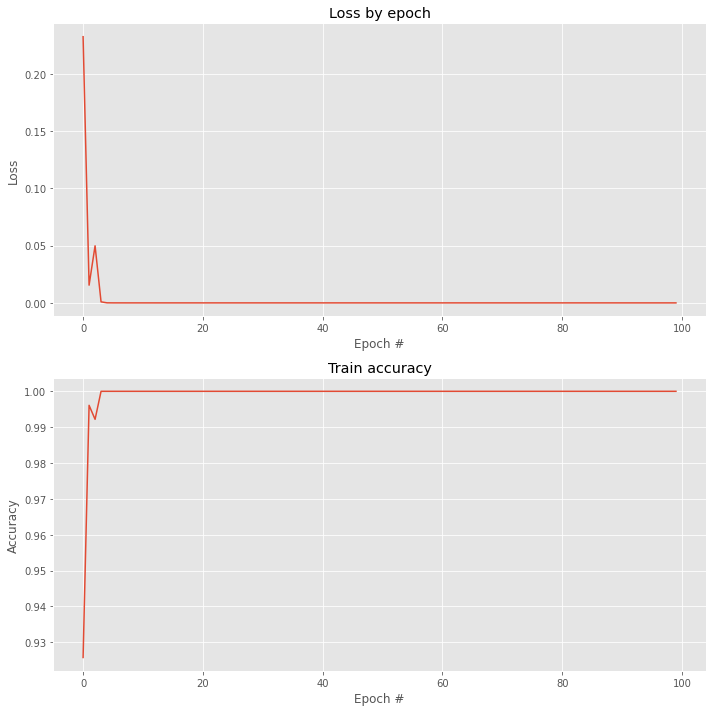

In [61]:
plot_nn_csv('plots/nn_1_est7.csv')

## Dataset 2: 40 clases

In [ ]:
DATASET_40 = datasets['dataset_40']

print(DATASET_40['x_train'].shape)

## Dataset 3: 100 clases

In [ ]:
DATASET_100 = datasets['dataset_100']

print(DATASET_100['x_train'].shape)

## Dataset 4: 166 clases

In [ ]:
DATASET_166 = datasets['dataset_166']

print(DATASET_166['x_train'].shape)

# BASE PARA PROBAR:

In [ ]:
# KNN 3
classifier = get_classifier('knn')
classifier.fit(x_train, y_train)

train_pred = classifier.predict(x_train)
test_pred = classifier.predict(x_test)

train_accuracy = accuracy_score(y_train, train_pred) * 100
test_accuracy = accuracy_score(y_test, test_pred) * 100

conf_matrix = confusion_matrix(y_test, test_pred)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}\n')

print(conf_matrix)

In [ ]:
# SVM
classifier = get_classifier('svm')
classifier.fit(x_train, y_train)

train_pred = classifier.predict(x_train)
test_pred = classifier.predict(x_test)

train_accuracy = accuracy_score(y_train, train_pred) * 100
test_accuracy = accuracy_score(y_test, test_pred) * 100

conf_matrix = confusion_matrix(y_test, test_pred)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}\n')

print(conf_matrix)

In [ ]:
# ADA
classifier = get_classifier('ada')
classifier.fit(x_train, y_train)

train_pred = classifier.predict(x_train)
test_pred = classifier.predict(x_test)

train_accuracy = accuracy_score(y_train, train_pred) * 100
test_accuracy = accuracy_score(y_test, test_pred) * 100

conf_matrix = confusion_matrix(y_test, test_pred)

print(f'\nTrain Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}\n')

print(conf_matrix)

In [ ]:
# NN with 2 hidden layers
feat_dimension = x_train[0].shape[0]
model = get_classifier('nn', options={'input_dim': feat_dimension, 'd1': 10, 'd2': 10, 'opt': 'adam'})

# Labels to one-hot encoding
categorical_train = np_utils.to_categorical(y_train, num_classes=NUM_OF_CLASSES)
categorical_test = np_utils.to_categorical(y_test, num_classes=NUM_OF_CLASSES)

# NN callbacks
csv_logger = CSVLogger('plots/nn_1.csv', separator=',', append=False)
early_stop = EarlyStopping(monitor='val_loss', patience=2)
callbacks = [csv_logger, early_stop]

start = datetime.now()

# TODO: use validation set to keep best model
model.fit(x_train, categorical_train, epochs=100, batch_size=4, verbose=1, callbacks=callbacks)

run_time = datetime.now() - start
print('Train time: ', run_time)

(loss, accuracy) = model.evaluate(x_test, categorical_test, batch_size=4, verbose=1)

print('Test Accuracy: ', accuracy * 100)

In [ ]:
plot_nn_csv('plots/nn_1.csv')